In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from scipy import stats
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
    VotingClassifier, RandomForestRegressor, ExtraTreesClassifier,
    StackingClassifier
)
from sklearn.linear_model import (
    LogisticRegression, SGDClassifier
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score,
    log_loss
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, StandardScaler
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, linear_model, neighbors, ensemble, tree
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.pipeline import make_pipeline

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

import pickle

os.environ['LOKY_MAX_CPU_COUNT'] = '4'

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from collections import defaultdict

# Suppress the specific warning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the CSV file with specified data types
df = pd.read_csv('final_dataset.csv', low_memory=False)

In [3]:
df.head()

,action_taken,loan_type,lien_status,open_end_line_of_credit,loan_amount,combined_loan_to_value_ratio,interest_rate,total_loan_costs,origination_charges,loan_term,...,applicant_ethnicity_1,co_applicant_ethnicity_1,applicant_race_1,applicant_race_2,co_applicant_race_1,co_applicant_race_2,applicant_sex,co_applicant_sex,applicant_age,co_applicant_age
0,3.0,3.0,1.0,2.0,205000.0,16.0,5.0,7.0,1.0,6.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,7.0,4.0
1,3.0,2.0,1.0,2.0,155000.0,7.0,5.0,7.0,1.0,6.0,...,2.0,2.0,5.0,5.0,5.0,5.0,2.0,1.0,3.0,3.0
2,3.0,2.0,1.0,2.0,125000.0,8.0,5.0,7.0,1.0,6.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,4.0,3.0
3,3.0,2.0,1.0,2.0,55000.0,7.0,5.0,7.0,1.0,6.0,...,2.0,2.0,3.0,5.0,3.0,5.0,1.0,2.0,2.0,2.0
4,3.0,1.0,1.0,2.0,345000.0,1.0,5.0,7.0,1.0,3.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,2.0,2.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54832 entries, 0 to 54831
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   action_taken                              54832 non-null  float64
 1   loan_type                                 54832 non-null  float64
 2   lien_status                               54832 non-null  float64
 3   open_end_line_of_credit                   54832 non-null  float64
 4   loan_amount                               54832 non-null  float64
 5   combined_loan_to_value_ratio              54832 non-null  float64
 6   interest_rate                             54832 non-null  float64
 7   total_loan_costs                          54832 non-null  float64
 8   origination_charges                       54832 non-null  float64
 9   loan_term                                 54832 non-null  float64
 10  negative_amortization             

In [5]:
random_state=42

In [6]:
# Define the minority classes for each column
minority_classes = {
    'applicant_sex': [2.0, 3.0, 6.0],
    'co_applicant_sex': [6.0, 1.0],
    'applicant_race_1': [3.0],
    'co_applicant_race_1': [3.0],
    'applicant_ethnicity_1': [1.0],
    'co_applicant_ethnicity_1': [1.0],
}

# Create a dictionary to store resampled datasets for each column
resampled_datasets = {}

# Create a new DataFrame to store the resampled data
resampled_df = df.copy()

# Iterate through the columns and apply SMOTE to each
for column, minority_class in minority_classes.items():
    # Select the specific column
    selected_column = df[column].values.reshape(-1, 1)

    # Define y_min based on the minority class for this column
    y_min = [1 if value in minority_class else 0 for value in df[column]]

    # Apply SMOTE to the selected column
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled2, y_resampled2 = smote.fit_resample(selected_column, y_min)

    # Ensure that the resampled data has the same number of rows as the original DataFrame
    if len(X_resampled2) > len(df):
        X_resampled2 = X_resampled2[:len(df)]
        y_resampled2 = y_resampled2[:len(df)]

    # Update the resampled data in the new DataFrame
    resampled_df[column] = X_resampled2.flatten()

In [7]:
resampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54832 entries, 0 to 54831
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   action_taken                              54832 non-null  float64
 1   loan_type                                 54832 non-null  float64
 2   lien_status                               54832 non-null  float64
 3   open_end_line_of_credit                   54832 non-null  float64
 4   loan_amount                               54832 non-null  float64
 5   combined_loan_to_value_ratio              54832 non-null  float64
 6   interest_rate                             54832 non-null  float64
 7   total_loan_costs                          54832 non-null  float64
 8   origination_charges                       54832 non-null  float64
 9   loan_term                                 54832 non-null  float64
 10  negative_amortization             

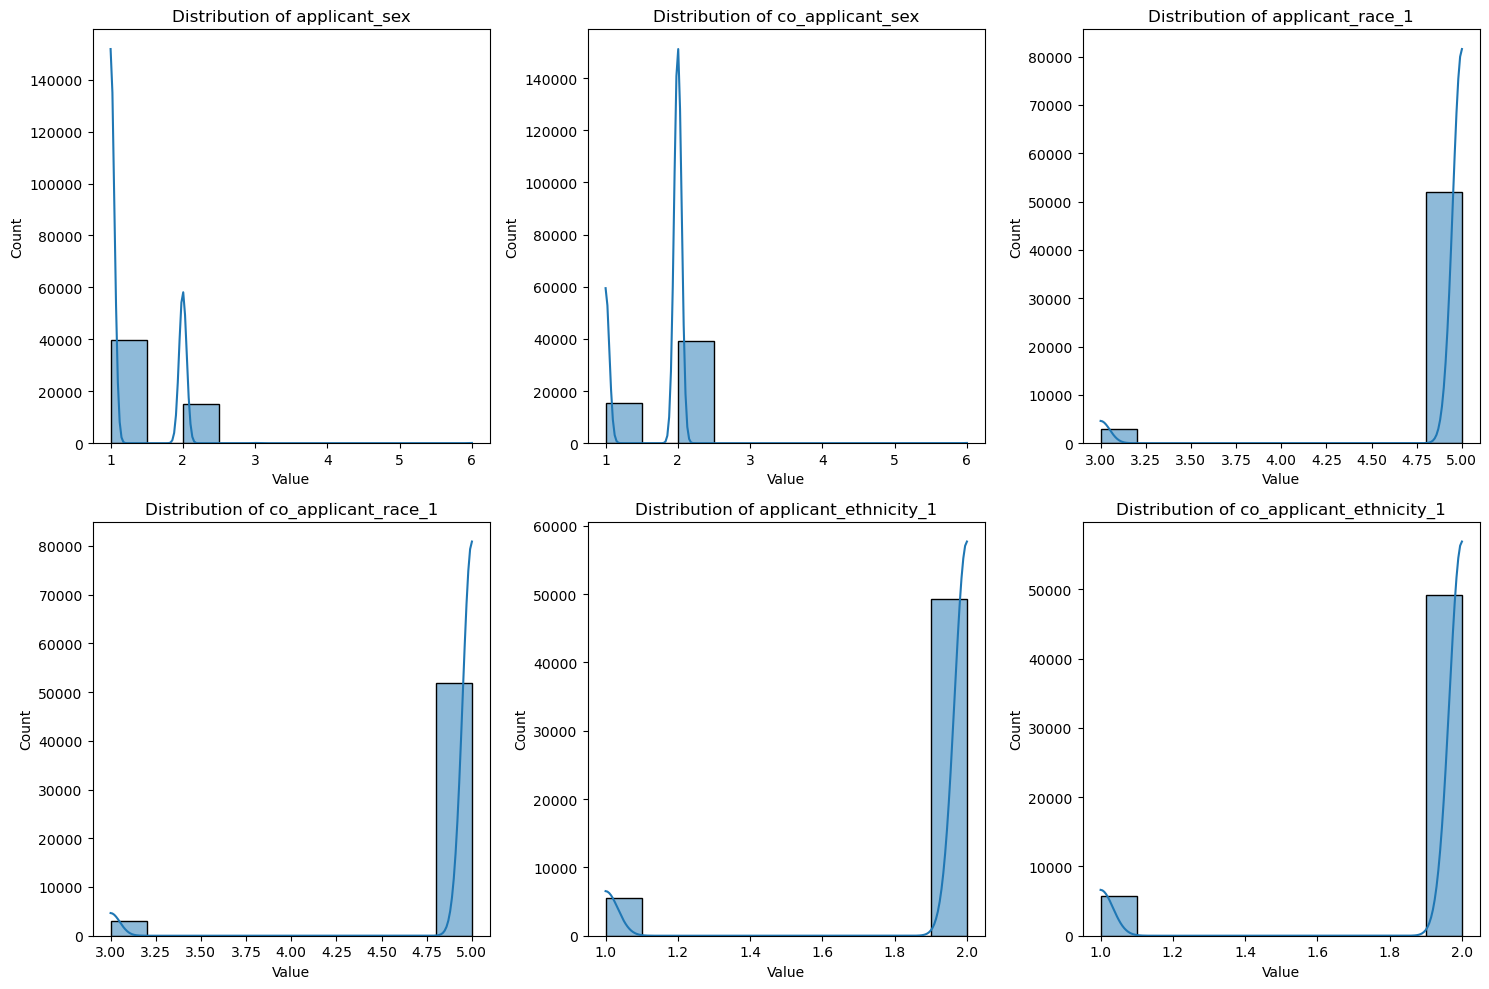

In [8]:
# Create a list of columns for which you want to plot the distribution
columns_to_plot = list(minority_classes.keys())

# Calculate the number of plots and rows
num_plots = len(columns_to_plot)
num_rows = (num_plots // 3) + (num_plots % 3)

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
axes = axes.ravel()

for i, column in enumerate(columns_to_plot):
    # Extract the resampled values for the current column from the resampled_df
    values = resampled_df[column]

    # Create a histogram plot
    g = sns.histplot(values, ax=axes[i], bins=10, kde=True)
    g.set_title(f'Distribution of {column}')
    g.set_xlabel("Value")
    g.set_ylabel("Count")

# Hide any empty subplots
for i in range(num_plots, num_rows * 3):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


# Logistic Regression

In [9]:
X = resampled_df.drop('action_taken', axis=1)
y = resampled_df['action_taken']

In [10]:
# Transform the labels
y = (y == 1).astype(int)

# Map class label 3 to 0
y[y == 3] = 0

In [11]:
# Split your data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Now, split the training data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [13]:
column_mapping = {i: col for i, col in enumerate(X_train.columns)}
column_mapping

{0: 'loan_type',
 1: 'lien_status',
 2: 'open_end_line_of_credit',
 3: 'loan_amount',
 4: 'combined_loan_to_value_ratio',
 5: 'interest_rate',
 6: 'total_loan_costs',
 7: 'origination_charges',
 8: 'loan_term',
 9: 'negative_amortization',
 10: 'interest_only_payment',
 11: 'balloon_payment',
 12: 'other_nonamortizing_features',
 13: 'property_value',
 14: 'occupancy_type',
 15: 'manufactured_home_secured_property_type',
 16: 'manufactured_home_land_property_interest',
 17: 'total_units',
 18: 'income',
 19: 'debt_to_income_ratio',
 20: 'applicant_credit_score_type',
 21: 'co_applicant_credit_score_type',
 22: 'applicant_ethnicity_1',
 23: 'co_applicant_ethnicity_1',
 24: 'applicant_race_1',
 25: 'applicant_race_2',
 26: 'co_applicant_race_1',
 27: 'co_applicant_race_2',
 28: 'applicant_sex',
 29: 'co_applicant_sex',
 30: 'applicant_age',
 31: 'co_applicant_age'}

In [14]:
LR = LogisticRegression(penalty='l2', max_iter=1000, C=1.0) 
LR.fit(X_train, y_train)

y_predict = LR.predict(X_train) 
print(f"The accuracy for training: {LR.score(X_train, y_train)}") 
print(f"The accuracy for validation: {LR.score(X_val, y_val)}") 

from sklearn.metrics import confusion_matrix, f1_score

# Make predictions on the test set
y_test_predict = LR.predict(X_test)

# Calculate the confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_predict)
print("Confusion Matrix for Test Set:")
print(cm)

# Calculate F1 score for the test set
f1_test = f1_score(y_test, y_test_predict)
print(f"F1 Score for Test Set: {f1_test}")


The accuracy for training: 0.5703864128576314
The accuracy for validation: 0.568904593639576
Confusion Matrix for Test Set:
[[ 114 4664]
 [  65 6124]]
F1 Score for Test Set: 0.7214466631324733


# KNeighborsClassifier

In [15]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Now, you can calculate the accuracy and F1 score
print('The accuracy for training : ', knn.score(X_train, y_train))
print('The accuracy for validation: ', knn.score(X_val, y_val))

# Make predictions on the test set
y_test_predict = knn.predict(X_test)

# Calculate the confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_predict)
print("Confusion Matrix for Test Set:")
print(cm)

# Calculate F1 score for the test set
f1_test = f1_score(y_test, y_test_predict)
print(f"F1 Score for Test Set: {f1_test}")


The accuracy for training :  0.7998404194688248
The accuracy for validation:  0.598540978000684
Confusion Matrix for Test Set:
[[2504 2274]
 [2101 4088]]
F1 Score for Test Set: 0.6514221974344674


# Naive Bayes

In [16]:
Gaussian = GaussianNB()
Gaussian.fit(X_train, y_train)
print('The accuracy for training : ',Gaussian.score(X_train,y_train))
print('The accuracy for validation: ',Gaussian.score(X_val,y_val))

# Make predictions on the test set
y_test_predict = Gaussian.predict(X_test)

# Calculate the confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_predict)
print("Confusion Matrix for Test Set:")
print(cm)

# Calculate F1 score for the test set
f1_test = f1_score(y_test, y_test_predict)
print(f"F1 Score for Test Set: {f1_test}")


The accuracy for training :  0.559700216573578
The accuracy for validation:  0.5519206656787872
Confusion Matrix for Test Set:
[[ 145 4633]
 [ 246 5943]]
F1 Score for Test Set: 0.7089770354906054


# Ada Boost Classifier

In [17]:
AB_CLF = AdaBoostClassifier(n_estimators=50, random_state=random_state)
AB_CLF.fit(X_train , y_train)
print('The accuracy for training : ',AB_CLF.score(X_train,y_train))
print('The accuracy for validation: ',AB_CLF.score(X_val,y_val))

# Make predictions on the test set
y_test_predict = AB_CLF.predict(X_test)

# Calculate the confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_predict)
print("Confusion Matrix for Test Set:")
print(cm)

# Calculate F1 score for the test set
f1_test = f1_score(y_test, y_test_predict)
print(f"F1 Score for Test Set: {f1_test}")

The accuracy for training :  0.985979710475322
The accuracy for validation:  0.9826741137581215
Confusion Matrix for Test Set:
[[4777    1]
 [ 147 6042]]
F1 Score for Test Set: 0.9879005886200132


# Stochastic Gradient Descent Algorithm

In [18]:
SG_PIP_CLF = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=100, tol=1e-3))
SG_PIP_CLF.fit(X_train , y_train)
print('The accuracy for training : ',SG_PIP_CLF.score(X_train,y_train))
print('The accuracy for validation: ',SG_PIP_CLF.score(X_val,y_val))

# Make predictions on the test set
y_test_predict = SG_PIP_CLF.predict(X_test)

# Calculate the confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_predict)
print("Confusion Matrix for Test Set:")
print(cm)

# Calculate F1 score for the test set
f1_test = f1_score(y_test, y_test_predict)
print(f"F1 Score for Test Set: {f1_test}")

The accuracy for training :  0.8949618146586117
The accuracy for validation:  0.8957027242676393
Confusion Matrix for Test Set:
[[4758   20]
 [1131 5058]]
F1 Score for Test Set: 0.8978432590751753


# XGBoost (eXtreme Gradient Boosting) - this takes a very long time!

In [19]:
# Add early stopping
early_stopping_rounds = 3

xgb_model1 = xgb.XGBClassifier(early_stopping_rounds=early_stopping_rounds)

parameters = {
    'nthread': [4],
    'objective': ['binary:logistic'],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.7],
    'n_estimators': [8000, 9000, 10000],
    'missing': [-999],
    'seed': [1337],
    'eval_metric': ['logloss'],
    'reg_alpha': [0.0, 0.1, 0.2],  # Test L1 regularization (0.0 means no L1 regularization)
    'reg_lambda': [0.0, 0.1, 0.2]  # Test L2 regularization (0.0 means no L2 regularization)
}

# Use 3-fold cross-validation
clf = GridSearchCV(xgb_model1, parameters, n_jobs=3,
                   cv=KFold(n_splits=3, shuffle=True, random_state=random_state),
                   scoring='neg_log_loss',  
                   verbose=4, refit=True)


# Implement early stopping
eval_set = [(X_val, y_val)]
clf.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
[0]	validation_0-logloss:0.54428
[1]	validation_0-logloss:0.45041
[2]	validation_0-logloss:0.35911
[3]	validation_0-logloss:0.32330
[4]	validation_0-logloss:0.26916
[5]	validation_0-logloss:0.23748
[6]	validation_0-logloss:0.19875
[7]	validation_0-logloss:0.16964
[8]	validation_0-logloss:0.14938
[9]	validation_0-logloss:0.13370
[10]	validation_0-logloss:0.11918
[11]	validation_0-logloss:0.10799
[12]	validation_0-logloss:0.10289
[13]	validation_0-logloss:0.09514
[14]	validation_0-logloss:0.09131
[15]	validation_0-logloss:0.08778
[16]	validation_0-logloss:0.08345
[17]	validation_0-logloss:0.07972
[18]	validation_0-logloss:0.07685
[19]	validation_0-logloss:0.07515
[20]	validation_0-logloss:0.07360
[21]	validation_0-logloss:0.07173
[22]	validation_0-logloss:0.07020
[23]	validation_0-logloss:0.06921
[24]	validation_0-logloss:0.06801
[25]	validation_0-logloss:0.06702
[26]	validation_0-logloss:0.06623
[27]	validation_0-logloss:0

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=3,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     intera...
             param_grid={'colsample_bytree': [0.7], 'eval_metric': ['logloss'],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 5, 10],
                         'missing': [-999], 'n_estimators': [8000, 9000, 10000],
                         'nthread': [4], 'objective': ['binary:logistic'],
                         'reg_alpha': [0.0, 0.1, 0.2],
                         'reg_lambda': [0.0, 0.1, 0.2], 'seed': [1337],
                         'subsample': [0.5, 0.7, 0.9]},
             scoring='neg_log_loss', verbose=4)

In [20]:
import joblib
# Save the grid search object
joblib.dump(clf, 'grid_search_xgboost.pkl')

['grid_search_xgboost.pkl']

In [21]:
clf.best_params_

{'colsample_bytree': 0.7,
 'eval_metric': 'logloss',
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': -999,
 'n_estimators': 8000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0.1,
 'reg_lambda': 0.0,
 'seed': 1337,
 'subsample': 0.9}

In [22]:
# Define your hyperparameters
params = {'colsample_bytree': 0.7,
 'eval_metric': 'logloss',
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': -999,
 'n_estimators': 8000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0.1,
 'reg_lambda': 0.0,
 'seed': 1337,
 'subsample': 0.9}

In [23]:
X_train

,loan_type,lien_status,open_end_line_of_credit,loan_amount,combined_loan_to_value_ratio,interest_rate,total_loan_costs,origination_charges,loan_term,negative_amortization,...,applicant_ethnicity_1,co_applicant_ethnicity_1,applicant_race_1,applicant_race_2,co_applicant_race_1,co_applicant_race_2,applicant_sex,co_applicant_sex,applicant_age,co_applicant_age
38004,1.0,1.0,2.0,225000.0,8.0,7.0,1.0,2.0,6.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,2.0,1.0,2.0,2.0
7191,1.0,1.0,2.0,195000.0,9.0,5.0,7.0,1.0,6.0,2.0,...,2.0,1.0,5.0,5.0,5.0,5.0,1.0,2.0,1.0,1.0
9193,1.0,1.0,2.0,705000.0,14.0,5.0,7.0,1.0,6.0,2.0,...,2.0,1.0,5.0,5.0,5.0,5.0,1.0,2.0,2.0,1.0
8752,1.0,1.0,2.0,215000.0,4.0,5.0,7.0,1.0,3.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,2.0,2.0
27397,1.0,1.0,2.0,125000.0,3.0,6.0,4.0,1.0,6.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,2.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14182,1.0,1.0,2.0,255000.0,2.0,5.0,7.0,1.0,6.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,1.0,1.0
37896,1.0,1.0,2.0,155000.0,9.0,6.0,2.0,2.0,6.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,7.0,7.0
37842,1.0,1.0,2.0,165000.0,8.0,8.0,3.0,2.0,3.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,2.0,2.0
34882,1.0,1.0,2.0,335000.0,1.0,6.0,5.0,1.0,6.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,2.0,2.0


In [24]:
# Train the model and monitor early stopping
xgb_model1.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Make predictions on the test set
y_predict = (xgb_model1.predict_proba(X_test)[:, 1] >= 0.59)

# Calculate precision and recall on the test set
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)

# Print test set results
print("Test set results:")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

# Calculate other evaluation metrics
accuracy = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Print other evaluation metrics
print("Test set results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

[0]	validation_0-logloss:0.44517
[1]	validation_0-logloss:0.31554
[2]	validation_0-logloss:0.23535
[3]	validation_0-logloss:0.18287
[4]	validation_0-logloss:0.14750
[5]	validation_0-logloss:0.12331
[6]	validation_0-logloss:0.10660
[7]	validation_0-logloss:0.09428
[8]	validation_0-logloss:0.08553
[9]	validation_0-logloss:0.07915
[10]	validation_0-logloss:0.07453
[11]	validation_0-logloss:0.07104
[12]	validation_0-logloss:0.06855
[13]	validation_0-logloss:0.06661
[14]	validation_0-logloss:0.06510
[15]	validation_0-logloss:0.06405
[16]	validation_0-logloss:0.06300
[17]	validation_0-logloss:0.06187
[18]	validation_0-logloss:0.06110
[19]	validation_0-logloss:0.06066
[20]	validation_0-logloss:0.06008
[21]	validation_0-logloss:0.05970
[22]	validation_0-logloss:0.05929
[23]	validation_0-logloss:0.05913
[24]	validation_0-logloss:0.05868
[25]	validation_0-logloss:0.05860
[26]	validation_0-logloss:0.05852
[27]	validation_0-logloss:0.05841
[28]	validation_0-logloss:0.05837
[29]	validation_0-loglos

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35092 entries, 38004 to 23712
Data columns (total 32 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   loan_type                                 35092 non-null  float64
 1   lien_status                               35092 non-null  float64
 2   open_end_line_of_credit                   35092 non-null  float64
 3   loan_amount                               35092 non-null  float64
 4   combined_loan_to_value_ratio              35092 non-null  float64
 5   interest_rate                             35092 non-null  float64
 6   total_loan_costs                          35092 non-null  float64
 7   origination_charges                       35092 non-null  float64
 8   loan_term                                 35092 non-null  float64
 9   negative_amortization                     35092 non-null  float64
 10  interest_only_payment              

In [26]:
import pickle

with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(xgb_model1, file)

In [27]:
import xgboost as xgb

# Assuming xgb_model1 is your trained XGBoost model
booster = xgb_model1.get_booster()

# Get feature names
feature_names = booster.feature_names
print(feature_names)

['loan_type', 'lien_status', 'open_end_line_of_credit', 'loan_amount', 'combined_loan_to_value_ratio', 'interest_rate', 'total_loan_costs', 'origination_charges', 'loan_term', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features', 'property_value', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest', 'total_units', 'income', 'debt_to_income_ratio', 'applicant_credit_score_type', 'co_applicant_credit_score_type', 'applicant_ethnicity_1', 'co_applicant_ethnicity_1', 'applicant_race_1', 'applicant_race_2', 'co_applicant_race_1', 'co_applicant_race_2', 'applicant_sex', 'co_applicant_sex', 'applicant_age', 'co_applicant_age']


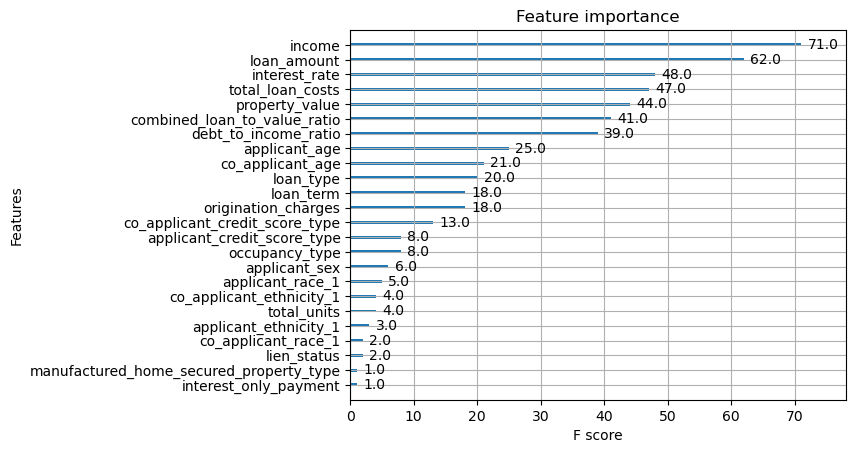

In [28]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming xgb_model1 is your trained XGBoost model
xgb.plot_importance(xgb_model1)
plt.show()

# Make test data for the webapp

We create a json file.
it contains 5 accepted rows and 5 declined rows.
We feed this to the form in our webapp to test predictions. 

In [29]:
accepted_counter = 0  # Initialize the accepted counter
dummy_data = []  # List to store the dummy data

for index, target_value in enumerate(y_test):
    if target_value == 1.0 and accepted_counter < 3:
        dummy_name = f"acceptedDummy{accepted_counter + 1}"
        print(index)
        dummy_row = X_test.iloc[index].copy()  # Create a copy of the row
        dummy_row['action_taken'] = 1.0  # Set the action_taken value to 1.0 for accepted
        dummy_data.append((dummy_name, dummy_row))
        accepted_counter += 1

dummy_data


0
1
2


[('acceptedDummy1',
  loan_type                                         1.0
  lien_status                                       1.0
  open_end_line_of_credit                           2.0
  loan_amount                                  545000.0
  combined_loan_to_value_ratio                     14.0
  interest_rate                                     6.0
  total_loan_costs                                  1.0
  origination_charges                               3.0
  loan_term                                         6.0
  negative_amortization                             2.0
  interest_only_payment                             2.0
  balloon_payment                                   2.0
  other_nonamortizing_features                      2.0
  property_value                              2405000.0
  occupancy_type                                    3.0
  manufactured_home_secured_property_type           3.0
  manufactured_home_land_property_interest          5.0
  total_units               

## Make a list of a few predictions and mirror them vs true labels.

In [30]:
X_test

,loan_type,lien_status,open_end_line_of_credit,loan_amount,combined_loan_to_value_ratio,interest_rate,total_loan_costs,origination_charges,loan_term,negative_amortization,...,applicant_ethnicity_1,co_applicant_ethnicity_1,applicant_race_1,applicant_race_2,co_applicant_race_1,co_applicant_race_2,applicant_sex,co_applicant_sex,applicant_age,co_applicant_age
29212,1.0,1.0,2.0,545000.0,14.0,6.0,1.0,3.0,6.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,3.0,4.0
37769,1.0,1.0,2.0,785000.0,4.0,5.0,3.0,2.0,6.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,2.0,1.0
23992,1.0,1.0,2.0,425000.0,1.0,4.0,9.0,1.0,6.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,2.0,2.0
18417,1.0,1.0,2.0,265000.0,4.0,5.0,7.0,1.0,6.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,4.0,3.0
54425,1.0,1.0,2.0,215000.0,2.0,4.0,10.0,7.0,3.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19244,1.0,1.0,2.0,235000.0,6.0,5.0,7.0,1.0,4.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,3.0,3.0
18378,1.0,1.0,2.0,505000.0,8.0,5.0,7.0,1.0,6.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,1.0,0.0
9725,1.0,1.0,2.0,165000.0,1.0,5.0,7.0,1.0,6.0,2.0,...,2.0,2.0,5.0,5.0,5.0,5.0,1.0,2.0,4.0,3.0
47680,2.0,1.0,2.0,145000.0,3.0,7.0,16.0,5.0,6.0,2.0,...,1.0,1.0,5.0,5.0,5.0,5.0,1.0,2.0,3.0,2.0


In [31]:
# Initialize lists to store predictions and true values
predictions = []
true_values = []

def make_predictions(xgb_model1, X_test, y_test, num_predictions=5):
    # Make predictions for the test dataset
    for _, testX in X_test.iterrows():
        yhat = xgb_model1.predict([testX.values])  # Make a one-step prediction
        predictions.append(yhat[0])  # Store the prediction

    # Make predictions for the true values
    for true_value in y_test:
        true_values.append(true_value)  # Store the true value

    # Return lists of predictions and true values
    return predictions[:num_predictions], true_values[:num_predictions]

# Example usage:
preds, true_vals = make_predictions(xgb_model1, X_test, y_test, num_predictions=5)

# Display the results
print("Predictions:", preds)
print("True Values:", true_vals)


Predictions: [1, 1, 1, 0, 1]
True Values: [1, 1, 1, 0, 1]


### See which rows are accepted.

In [32]:
# Create a DataFrame with predictions and true values
results_df = pd.DataFrame({'Predictions': predictions, 'True_Values': true_values})

# Filter rows where Predictions are 1 (accepted)
accepted_rows = results_df[results_df['Predictions'] == 1]

# Display the accepted rows
print(accepted_rows)

       Predictions  True_Values
0                1            1
1                1            1
2                1            1
4                1            1
5                1            1
...            ...          ...
10957            1            1
10959            1            1
10961            1            1
10965            1            1
10966            1            1

[6042 rows x 2 columns]


### Pick a specific accepted row and see its values.

In [33]:
import joblib
model_xgboost = joblib.load('xgboost_model.pkl') 

In [34]:
row = X_test.iloc[7]
true_label = y_test.iloc[7]

prediction = xgb_model1.predict([row])
if prediction == true_label:
    print("Model prediction is correct.", true_label)
else:
    print("Model prediction is incorrect.", true_label)

Model prediction is correct. 1


In [35]:
row = X_test.iloc[7]
true_label = y_test.iloc[7]

prediction = model_xgboost.predict([row])
if prediction == true_label:
    print("Model prediction is correct.", true_label)
else:
    print("Model prediction is incorrect.", true_label)

Model prediction is correct. 1


In [36]:
row = X_test.iloc[147]
print(row)
true_label = y_test.iloc[147]

prediction = xgb_model1.predict([row])
if prediction == true_label:
    print("Model prediction is correct.", true_label)
else:
    print("Model prediction is incorrect.", true_label)

loan_type                                        1.0
lien_status                                      1.0
open_end_line_of_credit                          2.0
loan_amount                                 185000.0
combined_loan_to_value_ratio                    13.0
interest_rate                                    6.0
total_loan_costs                                 5.0
origination_charges                              2.0
loan_term                                        6.0
negative_amortization                            2.0
interest_only_payment                            2.0
balloon_payment                                  2.0
other_nonamortizing_features                     2.0
property_value                              505000.0
occupancy_type                                   1.0
manufactured_home_secured_property_type          3.0
manufactured_home_land_property_interest         5.0
total_units                                      1.0
income                                        

In [37]:
row = X_test.iloc[147]
true_label = y_test.iloc[147]

prediction = model_xgboost.predict([row])
if prediction == true_label:
    print("Model prediction is correct.", true_label)
else:
    print("Model prediction is incorrect.", true_label)

Model prediction is correct. 1


In [38]:
# Ensure that data_values has the correct format and values
data_values = X_test.iloc[6]  # accept: 0,3,6
data_values

loan_type                                        1.0
lien_status                                      1.0
open_end_line_of_credit                          2.0
loan_amount                                 305000.0
combined_loan_to_value_ratio                     1.0
interest_rate                                    5.0
total_loan_costs                                 3.0
origination_charges                              2.0
loan_term                                        6.0
negative_amortization                            2.0
interest_only_payment                            2.0
balloon_payment                                  2.0
other_nonamortizing_features                     2.0
property_value                              385000.0
occupancy_type                                   1.0
manufactured_home_secured_property_type          3.0
manufactured_home_land_property_interest         5.0
total_units                                      1.0
income                                        

In [39]:
# problematic prediction
prediction2 = model_xgboost.predict([data_values])
print(prediction2)  # This should be 1 if data_values now match the expected format and values

[1]


In [40]:
row1 = X_test.iloc[147]
np.save('row1.npy', row1)
row1

loan_type                                        1.0
lien_status                                      1.0
open_end_line_of_credit                          2.0
loan_amount                                 185000.0
combined_loan_to_value_ratio                    13.0
interest_rate                                    6.0
total_loan_costs                                 5.0
origination_charges                              2.0
loan_term                                        6.0
negative_amortization                            2.0
interest_only_payment                            2.0
balloon_payment                                  2.0
other_nonamortizing_features                     2.0
property_value                              505000.0
occupancy_type                                   1.0
manufactured_home_secured_property_type          3.0
manufactured_home_land_property_interest         5.0
total_units                                      1.0
income                                        

In [41]:
# correct prediction
prediction1 = model_xgboost.predict([row1])
print(prediction1)

[1]


# Pickle models

In [42]:
lr_model = linear_model.LogisticRegression(solver="lbfgs", random_state=random_state)
dt_model = tree.DecisionTreeClassifier(max_depth=8)
ADA_model = AdaBoostClassifier(n_estimators=50, random_state=random_state)
SGD_model = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=100, tol=1e-3))

models = ["lr_model","dt_model","ADA_model","SGD_model"]

In [43]:
for model_name in models:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_train, y_train)
    
    with open(f"{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

In [44]:
model_names = ["lr_model","dt_model","ADA_model","SGD_model"]

for model_name in model_names:
    with open(f"{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [45]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_train, y_train)}')
    print(f'{model_name} score: {curr_model.score(X_val, y_val)}')

lr_model score: 0.5703864128576314
lr_model score: 0.568904593639576
dt_model score: 0.985979710475322
dt_model score: 0.982788099851818
ADA_model score: 0.985979710475322
ADA_model score: 0.9826741137581215
SGD_model score: 0.8991508036019605
SGD_model score: 0.9023139177020404


# voting classifer (HARD)

In [46]:
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model', LogisticRegression(random_state=42)),
                             ('dt_model', DecisionTreeClassifier(max_depth=8)),
                             ('ADA_model', AdaBoostClassifier(random_state=42)),
                             ('SGD_model',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('sgdclassifier',
                                               SGDClassifier(max_iter=100))]))],
                 n_jobs=-1)

In [47]:
y_pred = voting_classifer.predict(X_train)
accuracy_score(y_train, y_pred)

0.9837569816482389

In [48]:
y_pred = voting_classifer.predict(X_val)
accuracy_score(y_val, y_pred)

0.9808503362589764

# Compare all the models.

In [52]:
import pandas as pd

# Example model and prediction data
models = ['LR', 'knn', 'Ada Boost', 'Gaussian', 'Stochastic Gradient Descent', 'xgb_model1', 'Decision Tree', 'SGD_model', 'voting_classifier']
y_pred1 = LR.predict(X_val)
y_pred2 = knn.predict(X_val)
y_pred3 = AB_CLF.predict(X_val)
y_pred4 = Gaussian.predict(X_val)
y_pred5 = SG_PIP_CLF.predict(X_val)
y_pred6 = xgb_model1.predict(X_val)
y_pred7 = dt_model.predict(X_val)
y_pred8 = SGD_model.predict(X_val)
y_pred9 = voting_classifer.predict(X_val)  

y_true = y_val  # True labels

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    'Models': models,  # Add the 'models' list as a column
    'Accuracy': [accuracy_score(y_true, y_pred1), accuracy_score(y_true, y_pred2), accuracy_score(y_true, y_pred3),
                 accuracy_score(y_true, y_pred4), accuracy_score(y_true, y_pred5), accuracy_score(y_true, y_pred6),
                 accuracy_score(y_true, y_pred7), accuracy_score(y_true, y_pred8), accuracy_score(y_true, y_pred9)],
    
    'Precision': [precision_score(y_true, y_pred1), precision_score(y_true, y_pred2), precision_score(y_true, y_pred3),
                  precision_score(y_true, y_pred4), precision_score(y_true, y_pred5), precision_score(y_true, y_pred6),
                  precision_score(y_true, y_pred7), precision_score(y_true, y_pred8), precision_score(y_true, y_pred9)],
    
    'Recall': [recall_score(y_true, y_pred1), recall_score(y_true, y_pred2), recall_score(y_true, y_pred3),
               recall_score(y_true, y_pred4), recall_score(y_true, y_pred5), recall_score(y_true, y_pred6),
               recall_score(y_true, y_pred7), recall_score(y_true, y_pred8), recall_score(y_true, y_pred9)],
    
    'F1 Score': [f1_score(y_true, y_pred1), f1_score(y_true, y_pred2), f1_score(y_true, y_pred3),
                 f1_score(y_true, y_pred4), f1_score(y_true, y_pred5), f1_score(y_true, y_pred6),
                 f1_score(y_true, y_pred7), f1_score(y_true, y_pred8), f1_score(y_true, y_pred9)]
}

# Create a DataFrame
df = pd.DataFrame(metrics)

# Display the DataFrame
print(df)


                        Models  Accuracy  Precision    Recall  F1 Score
0                           LR  0.568905   0.567116  0.989064  0.720886
1                          knn  0.598541   0.641543  0.649858  0.645674
2                    Ada Boost  0.982674   0.999791  0.969421  0.984372
3                     Gaussian  0.551921   0.559565  0.957878  0.706445
4  Stochastic Gradient Descent  0.895703   0.994834  0.818955  0.898367
5                   xgb_model1  0.982788   1.000000  0.969421  0.984473
6                Decision Tree  0.982788   1.000000  0.969421  0.984473
7                    SGD_model  0.902314   0.988508  0.836168  0.905979
8            voting_classifier  0.980850   1.000000  0.965978  0.982695


In [53]:
# Save to CSV with the index column
df.to_csv('model_comparison.csv', index=False)

# AWI - AOD

Rättvisa mätvärden:
Studien introducerar ett nytt rättvisemått som kallas "alternate world index (AWI)" för att utvärdera rättvisa för data med flera känsliga parametrar och alternativ.
AWI kvantifierar de partiska förutsägelserna inom en datauppsättning med hjälp av kontrafakta.
Dessutom använder studien "average odds difference (AOD)" som en jämförelsemetod för rättvisa utvärdering.
AOD mäter den genomsnittliga skillnaden mellan falska positiva siffror och sanna positiva siffror för oprivilegierade och privilegierade grupper.

In [54]:
from sklearn.metrics import average_precision_score, roc_auc_score

y_true = y_val  # True labels

def calculate_AWI(y_true, y_pred, sensitive_group):
    mask = sensitive_group == 1 # Identify unprivileged group
    prob_unprivileged = y_pred[mask]
    prob_privileged = y_pred[~mask]

    awi = (average_precision_score(y_true[mask], prob_unprivileged) - average_precision_score(y_true[~mask], prob_privileged))
    return awi

def calculate_AOD(y_true, y_pred, sensitive_group):
    mask = sensitivegroup == 1 # Identify unprivileged group
    fpr_unprivileged, tpr_unprivileged, = roc_curve(y_true[mask], y_pred[mask])
    fpr_privileged, tpr_privileged, = roc_curve(y_true[~mask], y_pred[~mask])

    aod = (abs(fpr_unprivileged - fpr_privileged).mean() +
    abs(tpr_unprivileged - tpr_privileged).mean()) / 2

    return aod

# Calculate AWI and AOD
awi = calculate_AWI(y_true, y_pred6, sensitive_group)
aod = calculate_AOD(y_true, y_pred6, sensitive_group)

# Evaluate fairness based on your criteria

if awi < threshold_AWI and aod < threshold_AOD:
    print("The model is considered fair.")
else:
    print("The model may have fairness issues and requires further examination or bias mitigation.")

NameError: name 'sensitive_group' is not defined